In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from MCEq.core import MCEqRun
import crflux.models as crf
plt.style.use('tableau-colorblind10')

In [2]:
detector_locations = {
    "IceCube": (-90, 0.),
    #"P-ONE": (47.9, -127.7,),
    "KM3NeT-ARCA": (36.6827, 15.1322,),
    #"KM3NeT-ORCA": (42.8, 6.0),
}
h_max = 100  # km
zeniths = [0, 90, 135, 180]
azimuths = [0,]
heights = np.linspace(h_max, 0, 100)*1e5 # in cm
date = "20120103"
detector = "IceCube"
download_dir = ""
eccodes_dir = None # Has to be changed to the path of the eccodes installation to use model lvl data
p_lvl_setup = (
    'ERA5Atmosphere',
    (date,
     detector_locations[detector],
     download_dir,
     "pressure_levels",
     eccodes_dir)
    )
if eccodes_dir is not None:
    model_lvl_setup = (
        'ERA5Atmosphere',
        (date,
        detector_locations[detector],
        download_dir,
        "model_lvl",
        eccodes_dir)
    )

In [3]:
p_lvl_mceq = MCEqRun(interaction_model="SIBYLL23C",
                     primary_model=(crf.HillasGaisser2012, 'H4a'),
                     density_model = p_lvl_setup,
                     theta_deg=0)
if eccodes_dir is not None:
    model_lvl_mceq = MCEqRun(interaction_model="SIBYLL23C",
                            primary_model=(crf.HillasGaisser2012, 'H4a'),
                            density_model = model_lvl_setup,
                            theta_deg=0)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to ERA5Atmosphere ('20120103', (-90, 0.0), '/data/user/jbottcher/AIRS_Data/AIRS_Download/', 'pressure_levels', '/home/jbottcher/.local/')
Data already downloaded to /data/user/jbottcher/AIRS_Data/AIRS_Download/2012/ERA5_20120103_12:00.grib


/home/jbottcher/software/MCEq/MCEq/geometry/geometry.py:36: RuntimeWarning: invalid value encountered in arcsin
  self.theta_max_rad = max(np.pi / 2.0, np.pi - np.arcsin(self.r_E / self.r_obs))


ERA5Atmosphere::set_theta(): shower latitude = -90.00, longitude =  0.00, local shower zenith angle =  0.00, for observed zenith angle =  0.00
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H4a)
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to ERA5Atmosphere ('20120103', (-90, 0.0), '/data/user/jbottcher/AIRS_Data/AIRS_Download/', 'model_lvl', '/home/jbottcher/.local/')


/data/user/jbottcher/venvs/MCEq_cuda_new/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024-12-20 09:14:37,058 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-20 09:14:37,058 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-20 09:14:37,059 INFO [2024-09-16T00:00:00] Remember that you need to have a

/data/user/jbottcher/AIRS_Data/AIRS_Download/2012/ERA5_Model_Lvl_single_day_20120103_12:00.grib2


/home/jbottcher/software/MCEq/MCEq/geometry/ECMWF_Download.py:228: RuntimeWarning: divide by zero encountered in divide
  alpha_k = 1-(p_low/delta_p_k)*np.log(p_up/p_low)
/home/jbottcher/software/MCEq/MCEq/geometry/ECMWF_Download.py:228: RuntimeWarning: invalid value encountered in multiply
  alpha_k = 1-(p_low/delta_p_k)*np.log(p_up/p_low)


ERA5Atmosphere::set_theta(): shower latitude = -90.00, longitude =  0.00, local shower zenith angle =  0.00, for observed zenith angle =  0.00
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H4a)


In [4]:
mceqs = {}
if eccodes_dir is not None:
    mceqs["Model Lvl"] = model_lvl_mceq
mceqs["Press Lvl"] = p_lvl_mceq
prod_yield = {}
X_depth = {}
temp = {}
for det, pos in detector_locations.items():
    prod_yield[det, "Press Lvl"] = np.zeros((len(p_lvl_mceq.e_grid), len(zeniths), len(azimuths), len(heights)))
    prod_yield[det, "Model Lvl"] = np.zeros((len(model_lvl_mceq.e_grid), len(zeniths), len(azimuths), len(heights)))
    X_depth[det, "Press Lvl"] = np.zeros((len(zeniths), len(azimuths), len(heights)))
    X_depth[det, "Model Lvl"] = np.zeros((len(zeniths), len(azimuths), len(heights)))
    temp[det, "Press Lvl"] = np.zeros((len(zeniths), len(azimuths), len(heights)))
    temp[det, "Model Lvl"] = np.zeros((len(zeniths), len(azimuths), len(heights)))
for det, pos in detector_locations.items():
    for label, mceq in mceqs.items():
        mceq.density_model.set_observer_location(pos)
        for j, z in enumerate(zeniths):
            for k, az in enumerate(azimuths):
                    mceq.density_model.set_theta(z, azimuth_deg=az)
                    mceq._calculate_integration_path(None, "X", force=True)
                    X_depth[det, label][j, k] = np.exp(mceq.density_model.s_h2X(heights))
                    mceq.solve(X_depth[det, label][j, k])
                    for i, h in enumerate(heights):
                        prod_yield[det, label][:, j, k, i] = mceq.get_solution("conv_numu", grid_idx = i, mag=0,) +\
                            mceq.get_solution("conv_antinumu", grid_idx = i, mag=0)
                    temp[det, label][j, k] = mceq.density_model.get_temperature(heights)


/home/jbottcher/software/MCEq/MCEq/geometry/geometry.py:36: RuntimeWarning: invalid value encountered in arcsin
  self.theta_max_rad = max(np.pi / 2.0, np.pi - np.arcsin(self.r_E / self.r_obs))


ERA5Atmosphere::set_theta(): shower latitude = -90.00, longitude =  0.00, local shower zenith angle =  0.00, for observed zenith angle =  0.00
ERA5Atmosphere::set_theta(): shower latitude = -90.00, longitude =  0.00, local shower zenith angle = 90.00, for observed zenith angle = 90.00


/tmp/ipykernel_7940/3179551270.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  mceq._calculate_integration_path(None, "X", force=True)


ERA5Atmosphere::set_theta(): shower latitude = -0.00, longitude =  0.00, local shower zenith angle = 45.00, for observed zenith angle = 135.00
ERA5Atmosphere::set_theta(): shower latitude = 90.00, longitude =  0.00, local shower zenith angle =  0.00, for observed zenith angle = 180.00
ERA5Atmosphere::set_theta(): shower latitude = -90.00, longitude =  0.00, local shower zenith angle =  0.00, for observed zenith angle =  0.00
ERA5Atmosphere::set_theta(): shower latitude = -90.00, longitude =  0.00, local shower zenith angle = 90.00, for observed zenith angle = 90.00


/tmp/ipykernel_7940/3179551270.py:22: RuntimeWarning: overflow encountered in exp
  X_depth[det, label][j, k] = np.exp(mceq.density_model.s_h2X(heights))
/data/user/jbottcher/venvs/MCEq_cuda_new/lib/python3.10/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


ERA5Atmosphere::set_theta(): shower latitude = -0.00, longitude =  0.00, local shower zenith angle = 45.00, for observed zenith angle = 135.00
ERA5Atmosphere::set_theta(): shower latitude = 90.00, longitude =  0.00, local shower zenith angle =  0.00, for observed zenith angle = 180.00
ERA5Atmosphere::set_theta(): shower latitude = 36.68, longitude = 15.13, local shower zenith angle =  0.00, for observed zenith angle =  0.00
ERA5Atmosphere::set_theta(): shower latitude = 36.68, longitude = 15.13, local shower zenith angle = 90.00, for observed zenith angle = 90.00
ERA5Atmosphere::set_theta(): shower latitude = 53.32, longitude = -164.87, local shower zenith angle = 45.00, for observed zenith angle = 135.00
ERA5Atmosphere::set_theta(): shower latitude = -36.68, longitude = -164.87, local shower zenith angle =  0.00, for observed zenith angle = 180.00
ERA5Atmosphere::set_theta(): shower latitude = 36.68, longitude = 15.13, local shower zenith angle =  0.00, for observed zenith angle =  0.

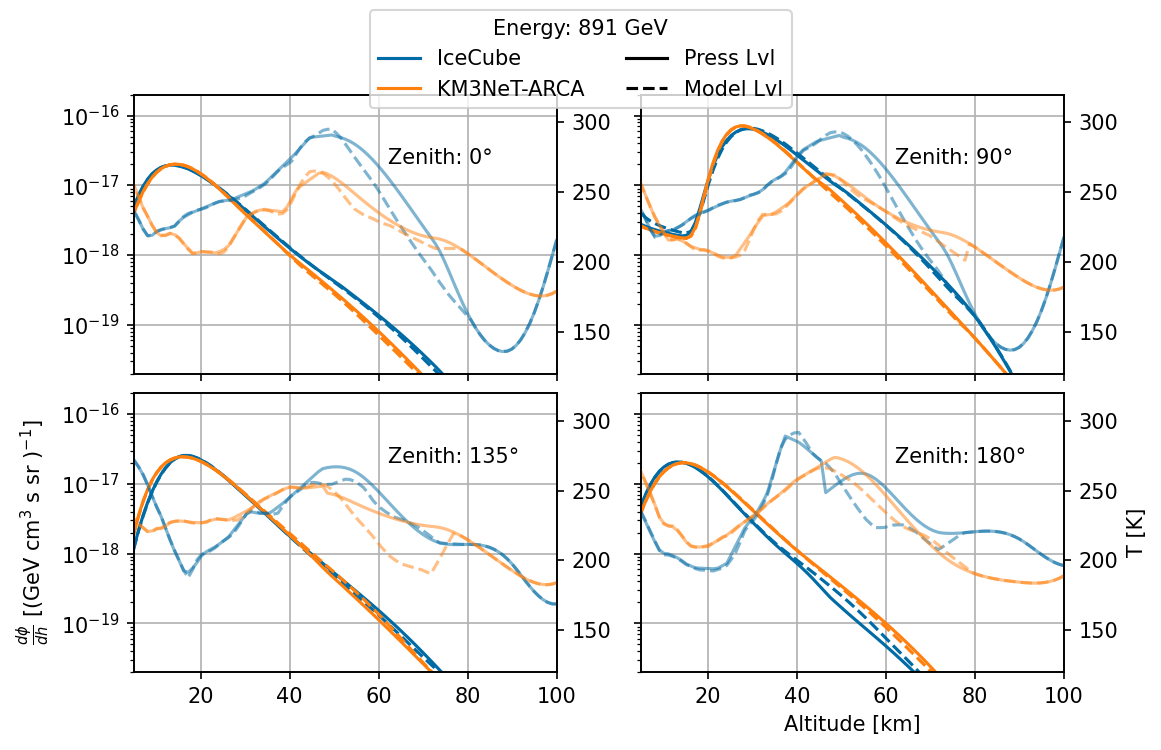

In [6]:
fig, axes = plt.subplots(len(zeniths)//2, 2,  
                         dpi=150,
                         sharex=True,
                         sharey=True,
                         figsize=(8, 5))
axes = axes.flatten()
e_idx = 40
linestyles ={
    "Press Lvl": "-",
    "Model Lvl": "--"
}
det_colors = {
    "IceCube": "C0",
    "P-ONE": "C2",
    "KM3NeT-ARCA": "C1",
    "KM3NeT-ORCA": "C3"
}
for j, z in enumerate(zeniths):
    ax2 = axes[j].twinx()
    ax2.set_ylim(120, 320)
    axes[j].grid(True)
    for det in detector_locations.keys():
        for label, mceq in mceqs.items():
            Prod_yield = -1*np.gradient(prod_yield[det, label][e_idx, j, 0, :],
                                        heights)
            axes[j].plot(heights/1e5,
                         Prod_yield,
                         linestyle=linestyles[label],
                         color=det_colors[det],)
            ax2.plot(heights/1e5, 
                     temp[det, label][j, 0],
                     linestyle=linestyles[label],
                     color=det_colors[det],
                     alpha=0.5)
    axes[j].text(62, 2e-17, f"Zenith: {z}°", )

for det in detector_locations.keys():
    axes[-1].plot([], [],
                  color=det_colors[det],
                  label=det)
for label in mceqs.keys():
    axes[-1].plot([], [],
                  linestyle=linestyles[label],
                  color="k",
                  label=label)

fig.legend(ncol=2,
           loc= "upper center",
           title=f"Energy: {p_lvl_mceq.e_grid[e_idx]:.0f} GeV")
fig.subplots_adjust(hspace=0.07, 
                    wspace=0.2)
ax2.set_ylabel("T [K]")
axes[2].set_ylabel(r"$\frac{d\phi}{dh}$ [(GeV cm$^3$ s sr )$^{-1}$]")
axes[-1].set_xlabel("Altitude [km]")
axes[0].set_ylim(2e-20, 2e-16)
axes[0].set_xlim(5, 100)
axes[0].set_yscale("log")

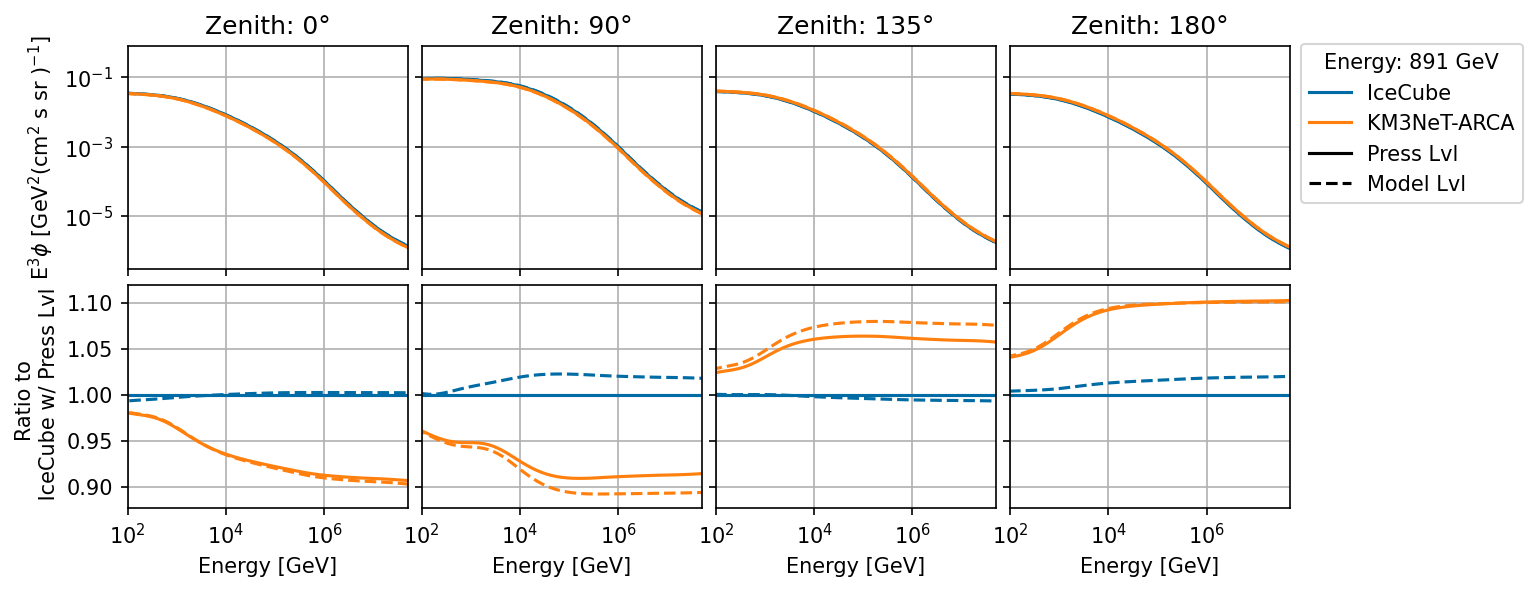

In [9]:
fig, axes = plt.subplots(2, len(zeniths),  
                         dpi=150,
                         sharex=True,
                         sharey="row",
                         figsize=(10, 4))
Baseline = ("IceCube", "Press Lvl", )
for j, z in enumerate(zeniths):
    ax = axes[0, j]
    ax2 = axes[1, j]
    axes[1, j].set_xlabel("Energy [GeV]")
    ax.grid(True)
    ax2.grid(True)
    for det in detector_locations.keys():
        for label, mceq in mceqs.items():
            ax.plot(mceq.e_grid,
                    mceq.e_grid**3*prod_yield[det, label][:, j, 0, -1],
                    linestyle=linestyles[label],
                    color = det_colors[det],)
            ax2.plot(mceq.e_grid, 
                     prod_yield[det, label][:, j, 0, -1]/prod_yield[Baseline][:, j, 0, -1],
                     linestyle=linestyles[label],
                     color = det_colors[det],)
    ax.set_title(f"Zenith: {z}°", )
for det in detector_locations.keys():
    axes[0, -1].plot([], [],
                    color=det_colors[det],
                    label=det)
for label in mceqs.keys():
    axes[0, -1].plot([], [],
                     linestyle=linestyles[label],
                     color="k", label=label)
fig.legend(ncol=1,
           bbox_to_anchor = (0.9,0.9),
           loc= "upper left",
           title=f"Energy: {p_lvl_mceq.e_grid[e_idx]:.0f} GeV")
fig.subplots_adjust(hspace=0.07, wspace=0.05)
axes[0, 0].set_ylabel(r"E$^3 \phi$ [GeV$^2$(cm$^2$ s sr )$^{-1}$]")
axes[1, 0].set_ylabel("Ratio to \n IceCube w/ Press Lvl")
axes[0, 0].set_ylim(3e-7, 8e-1)
axes[0, 0].set_xlim(1e2, 5e7)
axes[0, 0].set_yscale("log")
axes[0, 0].set_xscale("log")